# Train and Predict.

## Preprocessing

In [1]:
import pandas as pd

In [2]:
train_x = pd.read_csv('./data/train_x.csv')
train_y = pd.read_csv('./data/train_y.csv', header=None)
test_x = pd.read_csv('./data/test_x.csv')

In [3]:
train_x

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [4]:
train_y

,0
0,0
1,0
2,0
3,0
4,0
...,...
32556,0
32557,1
32558,0
32559,0


## Featuretools

欠損値の補間

In [5]:
train_x = train_x.fillna(value='?')
test_x = test_x.fillna(value='?')

In [6]:
import featuretools as ft

In [7]:
es = ft.EntitySet(id="adult_dataset")

In [8]:
train_x['sex'] = train_x['sex'] == 'Male'
test_x['sex'] = test_x['sex'] == 'Male'

In [9]:
test_x['sex']

0         True
1         True
2         True
3         True
4        False
         ...  
16276    False
16277     True
16278     True
16279     True
16280     True
Name: sex, Length: 16281, dtype: bool

In [10]:
es = es.entity_from_dataframe(
    entity_id='root',
    index='',
    dataframe=train_x,
    variable_types={
        'sex': ft.variable_types.Boolean,
    })
es

2019-12-19 02:51:05,183 featuretools.entityset - WARNING    index  not found in dataframe, creating new integer column


Entityset: adult_dataset
  Entities:
    root [Rows: 32561, Columns: 15]
  Relationships:
    No relationships

In [11]:
feature_matrix, feature_defs = ft.dfs(
        entityset=es,
        target_entity='root',
        trans_primitives=[
            'percentile', 'absolute',
        ])

In [12]:
feature_defs

[<Feature: age>,
 <Feature: workclass>,
 <Feature: fnlwgt>,
 <Feature: education>,
 <Feature: education-num>,
 <Feature: marital-status>,
 <Feature: occupation>,
 <Feature: relationship>,
 <Feature: race>,
 <Feature: capital-gain>,
 <Feature: capital-loss>,
 <Feature: hours-per-week>,
 <Feature: native-country>,
 <Feature: sex>,
 <Feature: PERCENTILE(hours-per-week)>,
 <Feature: PERCENTILE(capital-gain)>,
 <Feature: PERCENTILE(age)>,
 <Feature: PERCENTILE(capital-loss)>,
 <Feature: PERCENTILE(education-num)>,
 <Feature: PERCENTILE(fnlwgt)>,
 <Feature: ABSOLUTE(hours-per-week)>,
 <Feature: ABSOLUTE(capital-gain)>,
 <Feature: ABSOLUTE(age)>,
 <Feature: ABSOLUTE(capital-loss)>,
 <Feature: ABSOLUTE(education-num)>,
 <Feature: ABSOLUTE(fnlwgt)>,
 <Feature: ABSOLUTE(PERCENTILE(fnlwgt))>,
 <Feature: ABSOLUTE(PERCENTILE(capital-gain))>,
 <Feature: ABSOLUTE(PERCENTILE(capital-loss))>,
 <Feature: ABSOLUTE(PERCENTILE(hours-per-week))>,
 <Feature: ABSOLUTE(PERCENTILE(education-num))>,
 <Feature: A

In [13]:
es = es.entity_from_dataframe(
    entity_id='root',
    index='',
    dataframe=test_x,
    variable_types={
        'sex': ft.variable_types.Boolean,
    })

test_feature_matrix, test_feature_defs = ft.dfs(
        entityset=es,
        target_entity='root',
        trans_primitives=[
            'percentile', 'absolute',
        ])

2019-12-19 02:51:05,904 featuretools.entityset - WARNING    index  not found in dataframe, creating new integer column


In [14]:
feature_defs == test_feature_defs

True

## Categorical encoding

https://blog.amedama.jp/entry/2018/06/05/231703

In [15]:
from sklearn import preprocessing

In [16]:
categorical_columns = [
    'workclass', 'education', 'marital-status', 'occupation', 'relationship',
    'race', 'capital-gain', 'native-country']

In [17]:
features = feature_matrix.append(test_feature_matrix, ignore_index=True)

for column in categorical_columns:
    le = preprocessing.LabelEncoder()
    le.fit(features[column])
    feature_matrix[column]= pd.Series(le.transform(feature_matrix[column])).astype('category')
    test_feature_matrix[column]= pd.Series(le.transform(test_feature_matrix[column])).astype('category')

In [18]:
feature_matrix

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,capital-gain,...,ABSOLUTE(age),ABSOLUTE(capital-loss),ABSOLUTE(education-num),ABSOLUTE(fnlwgt),ABSOLUTE(PERCENTILE(fnlwgt)),ABSOLUTE(PERCENTILE(capital-gain)),ABSOLUTE(PERCENTILE(capital-loss)),ABSOLUTE(PERCENTILE(hours-per-week)),ABSOLUTE(PERCENTILE(education-num)),ABSOLUTE(PERCENTILE(age))
,,,,,,,,,,,,,,,,,,,,,
0,39,7,77516,9,13,4,1,1,4,27,...,39,0,13,77516,0.120389,0.922776,0.47669,0.472099,0.834495,0.550244
1,50,6,83311,9,13,2,4,0,4,0,...,50,0,13,83311,0.132106,0.458370,0.47669,0.028623,0.834495,0.792374
2,38,4,215646,11,9,0,6,1,4,0,...,38,0,9,215646,0.686496,0.458370,0.47669,0.472099,0.291883,0.525015
3,53,4,234721,1,7,2,6,0,2,0,...,53,0,7,234721,0.743036,0.458370,0.47669,0.472099,0.099291,0.841697
4,28,4,338409,9,13,2,10,5,2,0,...,28,0,13,338409,0.910875,0.458370,0.47669,0.472099,0.834495,0.259974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,4,257302,7,12,2,13,5,4,0,...,27,0,12,257302,0.794908,0.458370,0.47669,0.229953,0.735880,0.233838
32557,40,4,154374,11,9,2,7,0,4,0,...,40,0,9,154374,0.383849,0.458370,0.47669,0.472099,0.291883,0.574967
32558,58,4,151910,11,9,6,1,4,4,0,...,58,0,9,151910,0.374390,0.458370,0.47669,0.472099,0.291883,0.902291


## Predict

In [19]:
from optuna.integration import lightgbm as lgb
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [20]:
X_train, X_eval, y_train, y_eval = train_test_split(feature_matrix, train_y, test_size=0.25, random_state=40)

In [21]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train)
lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
}

model = lgb.train(
        lgb_params, lgb_train,
        valid_sets=lgb_eval,
        early_stopping_rounds=20,
        num_boost_round=300,
        verbose_eval=False,
)

tune_num_leaves, val_score: 0.928744: 100%|##########| 20/20 [00:09<00:00,  2.20it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.928744:  10%|#         | 1/10 [00:00<00:01,  4.84it/s][I 2019-12-19 02:51:19,348] Finished trial#0 resulted in value: 0.9278173827460323. Current best value is 0.9278173827460323 with parameters: {'bagging_fraction': 0.6948417319409619, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.928744:  20%|##        | 2/10 [00:00<00:01,  4.53it/s][I 2019-12-19 02:51:19,606] Finished trial#1 resulted in value: 0.9249452093459744. Current best value is 0.9278173827460323 with parameters: {'bagging_fraction': 0.6948417319409619, 'bagging_freq': 5}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.928744:  30%|###       | 3/10 [00:00<00:02,  3.28it/s][I 2019-12-19 02:51:20,106] Finished trial#2 resulted in value: 0.9281673327812856. Current best value is 0.9281673327812856 with parameters: {'bagging_fraction': 0.7991862909776216, 'bag

tune_bagging_fraction_and_bagging_freq, val_score: 0.928744:  40%|####      | 4/10 [00:01<00:01,  3.46it/s][I 2019-12-19 02:51:20,358] Finished trial#3 resulted in value: 0.9256597060436105. Current best value is 0.9281673327812856 with parameters: {'bagging_fraction': 0.7991862909776216, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.928744:  50%|#####     | 5/10 [00:01<00:01,  3.16it/s][I 2019-12-19 02:51:20,738] Finished trial#4 resulted in value: 0.9271578694107013. Current best value is 0.9281673327812856 with parameters: {'bagging_fraction': 0.7991862909776216, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.928744:  60%|######    | 6/10 [00:01<00:01,  2.93it/s][I 2019-12-19 02:51:21,145] Finished trial#5 resulted in value: 0.9281365404583243. Current best value is 0.9281673327812856 with parameters: {'bagging_fraction': 0.7991862909776216, 'bagging_freq': 7}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.928744:  70%|####

tune_lambda_l1_and_lambda_l2, val_score: 0.929023:  70%|#######   | 14/20 [00:05<00:02,  2.40it/s][I 2019-12-19 02:51:30,139] Finished trial#13 resulted in value: 0.9285658289022729. Current best value is 0.929023449563487 with parameters: {'lambda_l1': 0.0003403346643231474, 'lambda_l2': 2.3275254591008334}.
tune_lambda_l1_and_lambda_l2, val_score: 0.929023:  75%|#######5  | 15/20 [00:06<00:02,  2.11it/s][I 2019-12-19 02:51:30,773] Finished trial#14 resulted in value: 0.9279680232181495. Current best value is 0.929023449563487 with parameters: {'lambda_l1': 0.0003403346643231474, 'lambda_l2': 2.3275254591008334}.
tune_lambda_l1_and_lambda_l2, val_score: 0.929023:  80%|########  | 16/20 [00:06<00:01,  2.16it/s][I 2019-12-19 02:51:31,189] Finished trial#15 resulted in value: 0.928329125732558. Current best value is 0.929023449563487 with parameters: {'lambda_l1': 0.0003403346643231474, 'lambda_l2': 2.3275254591008334}.
tune_lambda_l1_and_lambda_l2, val_score: 0.929023:  85%|########5 | 

In [22]:
submit_pred = model.predict(test_feature_matrix)

In [23]:
submit_pred

array([0.0028113 , 0.16086458, 0.31154319, ..., 0.81570735, 0.03296932,
       0.8053472 ])

In [24]:
len(submit_pred)

16281

In [25]:
pd.Series(submit_pred).to_csv('./output/pred.csv', index=False, header=False)

## 特徴量の重要度を可視化

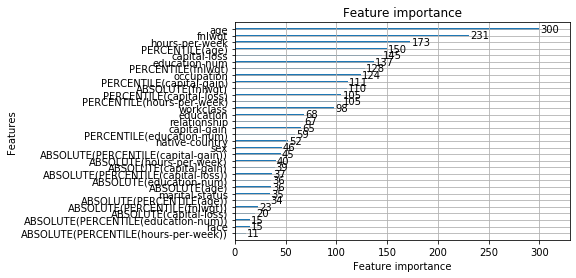

In [26]:
%matplotlib inline

from lightgbm.plotting import plot_importance

plot_importance(model)